In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [153]:
def cubic_spline_interpolation(q_,t_end, m): # time problem
    """
    Cubic Spline Interpolation

    ...

    Parameters
    ---
    q_  : Array of Position (n x Dof)
    t : timestamp corresponding to the points
    m(Optional) : Discrete Time Steps

    Returns
    ---
    q, qd, qdd : Position, Velocity and Acceleration (Dof x m)
    """
    n = q_.shape[0]
    dof = q_.shape[1]

    q_ = np.transpose(q_)

    m = m + (m % (n-1))
    k = int(m / (n-1))
    timesteps = [np.linspace(0, 1, num = k, endpoint = False) for i in range(n-2)]
    timesteps.append(np.linspace(0, 1, num = k))

    # Generate A matrix
    A = np.zeros((dof, n, n))
    # for zero acceleration
    A[:, 0, 0] = 2
    A[:, 0, 1] = 1
    A[:, n-1, n-2] = 1
    A[:, n-1, n-1] = 2
    
    # for zero velocity
    # A[:, 0, 0] = 1
    # A[:, n-1, n-1] = 1
    for i in range(1, n-1):
        A[:, i, i - 1] = 1
        A[:, i, i] = 4
        A[:, i, i + 1] = 1

    # Generate b matrix
    y = np.zeros((dof, n))
    y[:, 0] = 3 * (q_[:, 1] - q_[:, 0])
    y[:, n-1] = 3 * (q_[:, n - 1] - q_[:, n - 2])
    y[:, 0] = 0
    # y[:, n-1] = 0
    for i in range(1, n-1):
        y[:, i] = 3 * (q_[:, i + 1] - q_[:, i - 1])

    # Solve D
    D = np.linalg.solve(A, y)

    # Calculate coefficients
    a = np.copy(q_[:, :n-1])
    b = np.copy(D[:, :n-1])
    c = np.zeros((dof, n-1))
    d = np.zeros((dof, n-1))
    for i in range(0, n-1):
        c[:, i] = 3 * (q_[:, i + 1] - q_[:, i]) - 2 * D[:, i] - D[:, i + 1]
        d[:, i] = 2 * (q_[:, i] - q_[:, i + 1]) + D[:, i] + D[:, i + 1]

    
    # Calculate Trajectories
    q = np.zeros((dof, m))
    qd = np.zeros((dof, m))
    qdd = np.zeros((dof, m))

    for j in range(n - 1):
        for i in range(len(timesteps[j])):
            t = timesteps[j][i]
            t_2 = t * t
            t_3 = t * t * t

            q[:, i + j * k] = a[:, j] + b[:, j] * t + c[:, j] * t_2 + d[:, j] * t_3
            
            
    dt = t_end/m
    for i in range(m-1):
        if i < 5:
            qd[:,i] = (q[:,i+1]-q[:,i])/dt
            qdd[:,i] = (qd[:,i+1]-qd[:,i])/dt
        else:
            qd[:,i] = (5*q[:,i+1]-3*q[:,i]-q[:,i-1]-q[:,i-2])/(8*dt)  
            qdd[:,i] = (qd[:,i+1]-3*qd[:,i]-qd[:,i-1]-qd[:,i-2])/(8*dt)
    # once this is done resample the trajectory to the given time space
    qd[:,-1] = qd[:,-2]
    qdd[:,-1] = qdd[:,-2]
    return q, qd, qdd
            
     

In [154]:
q  = np.array([
              [-2,-1,0,1,2,3],
              [-5, 0,1,0,1,2],
              [0, 1,2,-1,0,1],
              [5, 2,3,-2,-1,0],
              [-10,3,4,-3,-2,-1],
            ])

t = np.array([0,0.2,0.4,0.6,0.8])

q,qd,qdd = cubic_spline_interpolation(q,t_end = 10, m =1000)
q.shape

(6, 1000)

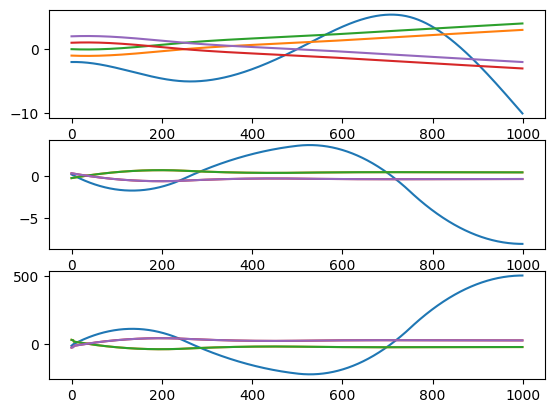

In [155]:
plt.figure()
for i in range(5):
    plt.subplot(3,1,1)
    plt.plot(q[i,:])
    
    plt.subplot(3,1,2)
    plt.plot(qd[i,:])
    
    plt.subplot(3,1,3)
    plt.plot(qdd[i,:])
    
    

In [94]:
def two_point_minjerk(q0, qf, T, m= 100):
    """
   Min Jerk Trajectory

    ...

    Parameters
    ---
    q0  : Initial Position
    qf  : Final Position 
    T : End Point
    m(Optional) : Discrete Time Steps

    Returns
    ---
    q, qd, qdd : Position, Velocity and Acceleration
    """
    
    # Q matix with starting and ending acceleration as zeros
    Q = np.zeros((6,1))
    Q[0,0] = q0
    Q[1,0] = qf
    
    # A matrix
    A = np.array([
                [0, 0, 0, 0, 0, 1],
                [T**5, T**4, T**3, T**2, T, 1],
                [0, 0, 0, 0, 1, 0],
                [5*T**4, 4*T**3, 3*T**2, 2*T, 1, 0],
                [0, 0, 0, 2, 0, 0],
                [20*T**3, 12*T**2, 6*T, 2, 0, 0],
                ])
    
    # the Coeffecient matrix
    C =np.linalg.solve(A,Q)
    
    q = np.zeros((m,))
    qd = np.zeros((m,))
    qdd = np.zeros((m,))
    
    t_span = np.linspace(0,T,m)
    
    for i in range(m):
        t = t_span[i]
        q[i] = C[0]*t**5 + C[1]*t**4 + C[2]*t**3 + C[3]*t**2 + C[4]*t + C[5]
        qd[i] = 5*C[0]*t**4 + 4*C[1]*t**3 + 3*C[2]*t**2 + 2*C[3]*t + C[4]
        qdd[i] = 20*C[0]*t**3 + 12*C[1]*t**2 + 6*C[2]*t + 2*C[3]
    return q, qd, qdd

In [128]:
def two_point_minsnap(q0, qf, T, m= 100):
    """
    Min Snap Trajectory

    ...

    Parameters
    ---
    q0  : Initial Position
    qf  : Final Position 
    T : End Point
    m(Optional) : Discrete Time Steps

    Returns
    ---
    q, qd, qdd : Position, Velocity and Acceleration
    """
    
    # Q matix with starting and ending acceleration as zeros
    Q = np.zeros((8,1))
    Q[0,0] = q0
    Q[1,0] = qf
    
    # A matrix
    A = np.array([
                [0, 0, 0, 0, 0, 0, 0, 1],
                [T**7, T**6, T**5, T**4, T**3, T**2, T, 1],
                [0, 0, 0, 0, 0, 0, 1, 0],
                [7*T**6, 6*T**5, 5*T**4, 4*T**3, 3*T**2, 2*T, 1, 0],
                [0, 0, 0, 0, 0, 2, 0, 0],
                [42*T**5, 30*T**4, 20*T**3, 12*T**2, 6*T, 2, 0, 0],
                [0, 0, 0, 0, 6, 0, 0, 0],
                [240*T**4, 120*T**3, 60*T**2, 24*T, 6, 0, 0, 0]
                ])
    # the Coeffecient matrix
    C =np.linalg.solve(A,Q)
    
    q = np.zeros((m,))
    qd = np.zeros((m,))
    qdd = np.zeros((m,))
    
    t_span = np.linspace(0,T,m)
    
    for i in range(m):
        t = t_span[i]
        q[i] = C[0]*t**7 + C[1]*t**6 + C[2]*t**5 + C[3]*t**4 + C[4]*t**3 + C[5]*t**2 + C[6]*t + C[7]
        qd[i] = 7*C[0]*t**6 + 6*C[1]*t**5 + 5*C[2]*t**4 + 4*C[3]*t**3 + 3*C[4]*t**2 + 2*C[5]*t + C[6]
        qdd[i] = 42*C[0]*t**5 + 30*C[1]*t**4 + 20*C[2]*t**3 + 12*C[3]*t**2 + 6*C[4]*t + 2*C[5]
    return q, qd, qdd

In [129]:
q_mjtp,qd_mjtp,qdd_mjtp = two_point_minjerk(0,2,10)
q_mstp,qd_mstp,qdd_mstp = two_point_minsnap(0,2,10)

Text(0, 0.5, 'qdd_mstp')

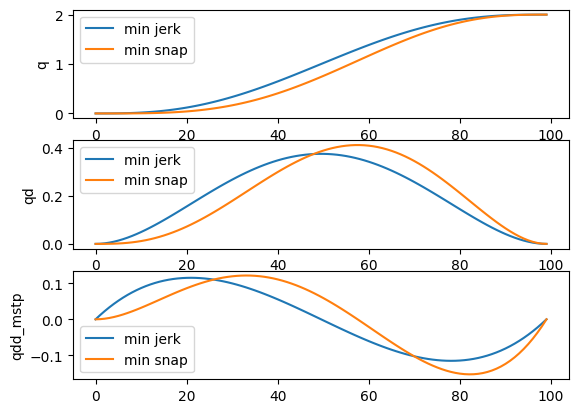

In [130]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(q_mjtp, label = 'min jerk')
plt.plot(q_mstp, label = 'min snap')
plt.legend()
plt.ylabel('q')

plt.subplot(3,1,2)
plt.plot(qd_mjtp, label = 'min jerk')
plt.plot(qd_mstp, label = 'min snap')
plt.legend()
plt.ylabel('qd')


plt.subplot(3,1,3)
plt.plot(qdd_mjtp, label = 'min jerk')
plt.plot(qdd_mstp, label = 'min snap')
plt.legend()
plt.ylabel('qdd_mstp')


In [124]:
def two_point_multiDOF_minjerk(q0, qf, T, m= 100):
    """
    Cubic Spline Interpolation

    ...

    Parameters
    ---
    q0  : Initial Position (DOF x 1)
    qf  : Final Position   (DOF x 1)
    T : End Point
    m(Optional) : Discrete Time Steps

    Returns
    ---
    q, qd, qdd : Position, Velocity and Acceleration (DOF x m)
    """
    
    # degrees of freedom
    dof = q0.shape[0]
    # Q matix with starting and ending acceleration as zeros
    Q = np.zeros((dof,6))
    Q[:,0] = q0.reshape(dof,)
    Q[:,1] = qf.reshape(dof,)

    # A matrix
    A = np.zeros((dof,6,6))
    for i in range(dof):
        A[i,:,:] = np.array([
                    [0, 0, 0, 0, 0, 1],
                    [T**5, T**4, T**3, T**2, T, 1],
                    [0, 0, 0, 0, 1, 0],
                    [5*T**4, 4*T**3, 3*T**2, 2*T, 1, 0],
                    [0, 0, 0, 2, 0, 0],
                    [20*T**3, 12*T**2, 6*T, 2, 0, 0],
                    ])

    # the Coeffecient matrix
    C =np.linalg.solve(A,Q)

    q = np.zeros((dof,m))
    qd = np.zeros((dof,m))
    qdd = np.zeros((dof,m))

    t_span = np.linspace(0,T,m)

    for i in range(m):
        t = t_span[i]
        q[:,i] = C[:,0]*t**5 + C[:,1]*t**4 + C[:,2]*t**3 + C[:,3]*t**2 + C[:,4]*t + C[:,5]
        qd[:,i] = 5*C[:,0]*t**4 + 4*C[:,1]*t**3 + 3*C[:,2]*t**2 + 2*C[:,3]*t + C[:,4]
        qdd[:,i] = 20*C[:,0]*t**3 + 12*C[:,1]*t**2 + 6*C[:,2]*t + 2*C[:,3]
    return q, qd, qdd

In [133]:
def two_point_multiDOF_minsnap(q0, qf, T, m= 100):
    """
    Cubic Spline Interpolation

    ...

    Parameters
    ---
    q0  : Initial Position (DOF x 1)
    qf  : Final Position   (DOF x 1)
    T : End Point
    m(Optional) : Discrete Time Steps

    Returns
    ---
    q, qd, qdd : Position, Velocity and Acceleration (DOF x m)
    """
    # degrees of freedom
    dof = q0.shape[0]
    
    Q = np.zeros((dof,8))
    Q[:,0] = q0.reshape(dof,)
    Q[:,1] = qf.reshape(dof,)

    # A matrix
    A = np.zeros((dof,8,8))
    for i in range(dof):
        A[i,:,:] = np.array([
                            [0, 0, 0, 0, 0, 0, 0, 1],
                            [T**7, T**6, T**5, T**4, T**3, T**2, T, 1],
                            [0, 0, 0, 0, 0, 0, 1, 0],
                            [7*T**6, 6*T**5, 5*T**4, 4*T**3, 3*T**2, 2*T, 1, 0],
                            [0, 0, 0, 0, 0, 2, 0, 0],
                            [42*T**5, 30*T**4, 20*T**3, 12*T**2, 6*T, 2, 0, 0],
                            [0, 0, 0, 0, 6, 0, 0, 0],
                            [240*T**4, 120*T**3, 60*T**2, 24*T, 6, 2, 0, 0],
                            ])
    # the Coeffecient matrix
    C =np.linalg.solve(A,Q)

    q = np.zeros((dof,m))
    qd = np.zeros((dof,m))
    qdd = np.zeros((dof,m))

    t_span = np.linspace(0,T,m)

    for i in range(m):
        t = t_span[i]
        q[:,i] = C[:,0]*t**7 + C[:,1]*t**6 + C[:,2]*t**5 + C[:,3]*t**4 + C[:,4]*t**3 + C[:,5]*t**2 + C[:,6]*t + C[:,7]
        qd[:,i] = 7*C[:,0]*t**6 + 6*C[:,1]*t**5 + 5*C[:,2]*t**4 + 4*C[:,3]*t**3 + 3*C[:,4]*t**2 + 2*C[:,5]*t + C[:,6]
        qdd[:,i] = 42*C[:,0]*t**5 + 30*C[:,1]*t**4 + 20*C[:,2]*t**3 + 12*C[:,3]*t**2 + 6*C[:,4]*t + 2*C[:,5]
    return q, qd, qdd

In [134]:
q0 = np.array([0,1,3,4])
qf = np.array([1,-3,5,-6])
T = 1


q_mjmtp,qd_mjmtp,qdd_mjmtp = two_point_multiDOF_minjerk(q0,qf,10)
q_msmtp,qd_msmtp,qdd_msmtp = two_point_multiDOF_minsnap(q0,qf,10)

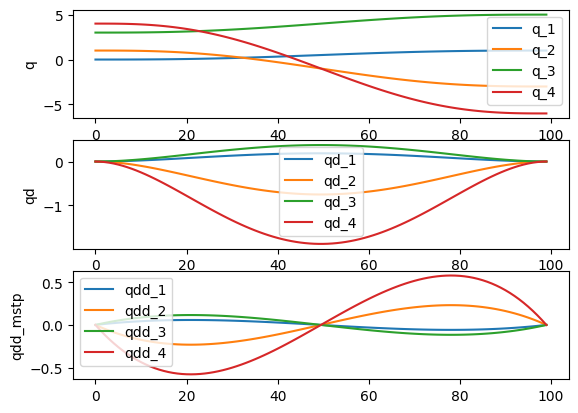

In [135]:

plt.figure()
for i in range(q0.shape[0]):
    plt.subplot(3,1,1)
    plt.plot(q_mjmtp[i,:], label = 'q_' + str(i+1))
    plt.ylabel('q')
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(qd_mjmtp[i,:], label = 'qd_' + str(i+1))
    plt.ylabel('qd')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(qdd_mjmtp[i,:], label = 'qdd_' + str(i+1))
    plt.ylabel('qdd_mstp')
    plt.legend()

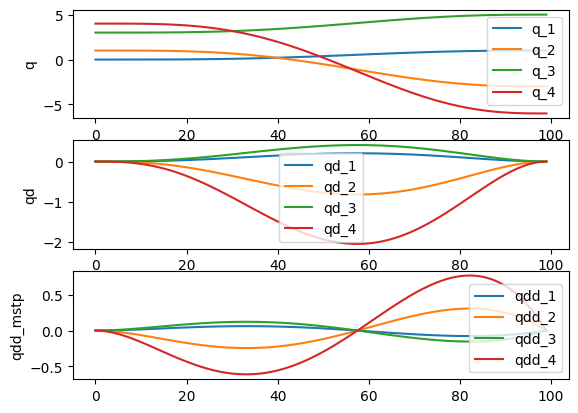

In [136]:
plt.figure()
for i in range(q0.shape[0]):
    plt.subplot(3,1,1)
    plt.plot(q_msmtp[i,:], label = 'q_' + str(i+1))
    plt.ylabel('q')
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(qd_msmtp[i,:], label = 'qd_' + str(i+1))
    plt.ylabel('qd')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(qdd_msmtp[i,:], label = 'qdd_' + str(i+1))
    plt.ylabel('qdd_mstp')
    plt.legend()